Scale Scikit-Learn for Small Data Problems
==========================================

This example demonstrates how Dask can scale scikit-learn to a cluster of machines for a CPU-bound problem.
We'll fit a large model, a grid-search over many hyper-parameters, on a small dataset.

This video talks demonstrates the same example on a larger cluster.

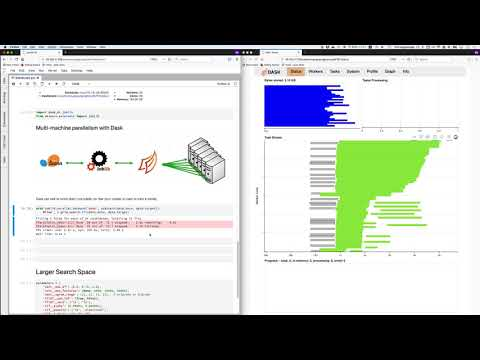

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("5Zf6DQaf7jk")

In [2]:
from dask.distributed import Client, progress
client = Client(n_workers=4, threads_per_worker=1, memory_limit='2GB')
client

<Client: 'tcp://127.0.0.1:39655' processes=4 threads=4, memory=7.45 GiB>

## Distributed Training

<img src="../images/scikit-learn-logo-notext.png"/> <img src="../images/joblib_logo.svg" width="20%"/> 

Scikit-learn uses [joblib](http://joblib.readthedocs.io/) for single-machine parallelism. This lets you train most estimators (anything that accepts an `n_jobs` parameter) using all the cores of your laptop or workstation.

Alternatively, Scikit-Learn can use Dask for parallelism.  This lets you train those estimators using all the cores of your *cluster* without significantly changing your code.

This is most useful for training large models on medium-sized datasets. You may have a large model when searching over many hyper-parameters, or when using an ensemble method with many individual estimators. For too small datasets, training times will typically be small enough that cluster-wide parallelism isn't helpful. For too large datasets (larger than a single machine's memory), the scikit-learn estimators may not be able to cope (though Dask-ML provides other ways for working with larger than memory datasets).

### Create Scikit-Learn Pipeline

In [3]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
# Scale Up: set categories=None to use all the categories
categories = [
    'alt.atheism',
    'talk.religion.misc',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']


857 documents
2 categories



We'll define a small pipeline that combines text feature extraction with a simple classifier.

In [5]:
pipeline = Pipeline([
    ('vect', HashingVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000)),
])

### Define Grid for Parameter Search

Grid search over some parameters.

In [6]:
parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    # 'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__n_iter': (10, 50, 80),
}

In [7]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3, refit=False)

To fit this normally, we would write


```python
grid_search.fit(data.data, data.target)
```

That would use the default joblib backend (multiple processes) for parallelism.
To use the Dask distributed backend, which will use a cluster of machines to train the model, perform the fit in a `parallel_backend` context.

In [8]:
import joblib

with joblib.parallel_backend('dask'):
    grid_search.fit(data.data, data.target)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


If you had your distributed dashboard open during that fit, you'll notice that each worker performs some of the fit tasks.

## Parallel, Distributed Prediction

Sometimes, you're train on a small dataset, but need to predict for a much larger batch of data.
In this case, you'd like your estimator to handle NumPy arrays and pandas DataFrames for training, and dask arrays or DataFrames for prediction. [`dask_ml.wrappers.ParallelPostFit`](http://ml.dask.org/modules/generated/dask_ml.wrappers.ParallelPostFit.html#dask_ml.wrappers.ParallelPostFit) provides exactly that. It's a meta-estimator. It does nothing during training; the underlying estimator (probably a scikit-learn estimator) will probably be in-memory on a single machine. But tasks like `predict`, `score`, etc. are parallelized and distributed.

Most of the time, using `ParallelPostFit` is as simple as wrapping the original estimator.
When used inside a GridSearch, you'll need to update the keys of the parameters, just like with any meta-estimator.
The only complication comes when using `ParallelPostFit` with another meta-estimator like `GridSearchCV`. In this case, you'll need to prefix your parameter names with `estimator__`.

In [9]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from dask_ml.wrappers import ParallelPostFit

We'll load the small NumPy arrays for training.

In [10]:
X, y = load_digits(return_X_y=True)
X.shape

(1797, 64)

In [11]:
svc = ParallelPostFit(SVC(random_state=0, gamma='scale'))

param_grid = {
    # use estimator__param instead of param
    'estimator__C': [0.01, 1.0, 10],
}

grid_search = GridSearchCV(svc, param_grid, cv=3)

And fit as usual.

In [12]:
grid_search.fit(X, y)

GridSearchCV(cv=3, estimator=ParallelPostFit(estimator=SVC(random_state=0)),
             param_grid={'estimator__C': [0.01, 1.0, 10]})

We'll simulate a large dask array by replicating the training data a few times.
In reality, you would load this from your file system.

In [13]:
import dask.array as da

In [14]:
big_X = da.concatenate([
    da.from_array(X, chunks=X.shape)
    for _ in range(10)
])
big_X

dask.array<concatenate, shape=(17970, 64), dtype=float64, chunksize=(1797, 64), chunktype=numpy.ndarray>

Operations like `predict`, or `predict_proba` return dask, rather than NumPy arrays.
When you compute, the work will be done in parallel, out of core or distributed on the cluster.

In [15]:
predicted = grid_search.predict(big_X)
predicted

dask.array<_predict, shape=(17970,), dtype=int64, chunksize=(1797,), chunktype=numpy.ndarray>

At this point predicted could be written to disk, or aggregated before returning to the client.